# Imports


In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Load data


In [35]:
baseline = pd.read_csv('baseline.csv')
experiment = pd.read_csv('experiment.csv')

baseline_error = baseline['error_angle_deg'].to_numpy()
experiment_error = experiment['error_angle_deg'].to_numpy()

print('Baseline trials:', len(baseline_error))
print('Experiment trials:', len(experiment_error))


Baseline trials: 160
Experiment trials: 400


# Plot errors with sections


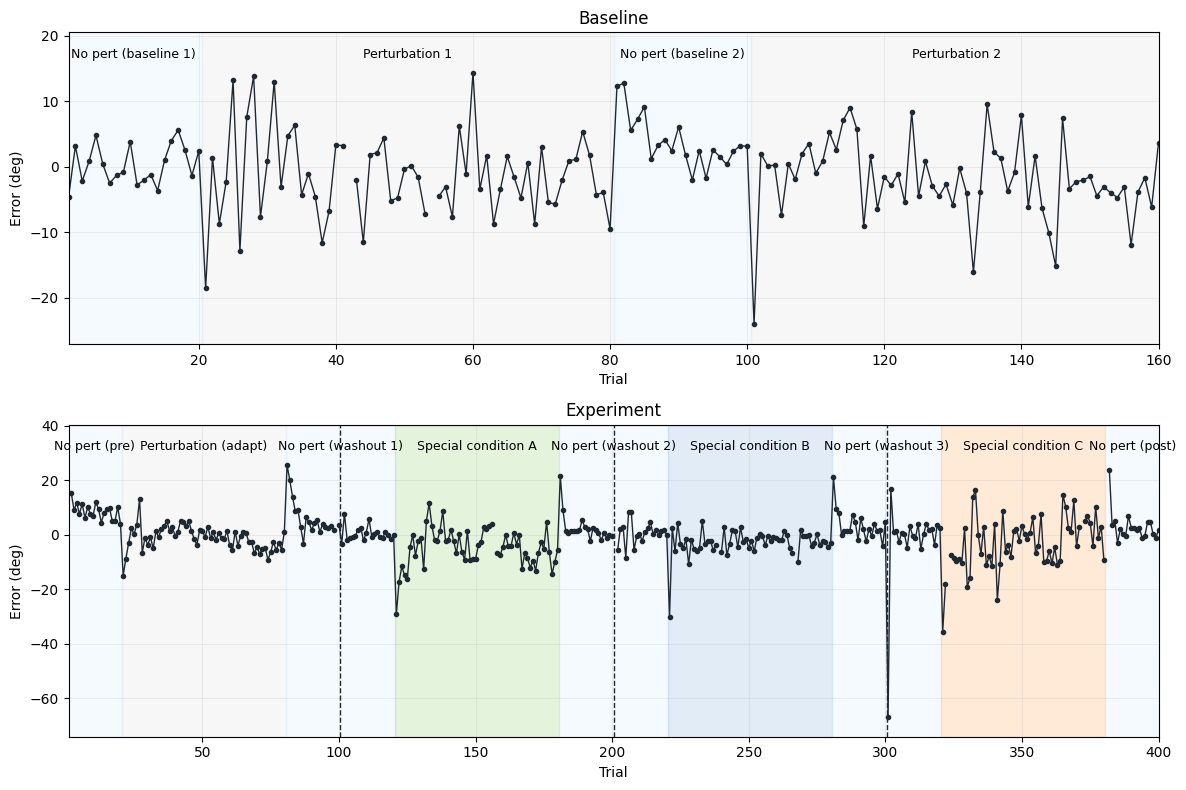

In [36]:
def build_segments(lengths, labels, colors, types):
    segments = []
    start = 1
    for length, label, color, seg_type in zip(lengths, labels, colors, types):
        end = start + length - 1
        segments.append({
            'start': start,
            'end': end,
            'label': label,
            'color': color,
            'type': seg_type,
        })
        start = end + 1
    return segments

def plot_error_with_segments(ax, errors, segments, title, switch_trials=None):
    x = np.arange(1, len(errors) + 1)
    ax.plot(x, errors, marker='o', markersize=3, linewidth=1, color='#1f2933')

    y_min = float(np.nanmin(errors))
    y_max = float(np.nanmax(errors))
    pad = max((y_max - y_min) * 0.08, 1.0)
    label_y = y_max + pad * 0.6

    for seg in segments:
        ax.axvspan(seg['start'] - 0.5, seg['end'] + 0.5, color=seg['color'], alpha=0.2)
        mid = (seg['start'] + seg['end']) / 2
        ax.text(mid, label_y, seg['label'], ha='center', va='bottom', fontsize=9)

    if switch_trials:
        for trial in switch_trials:
            boundary = trial - 0.5
            ax.axvline(boundary, color='#1f2933', linestyle='--', linewidth=1)

    ax.set_xlim(1, len(errors))
    ax.set_ylim(y_min - pad, y_max + pad * 2)
    ax.set_xlabel('Trial')
    ax.set_ylabel('Error (deg)')
    ax.set_title(title)
    ax.grid(True, alpha=0.2)

baseline_segments = build_segments(
    lengths=[20, 60, 20, 60],
    labels=[
        'No pert (baseline 1)',
        'Perturbation 1',
        'No pert (baseline 2)',
        'Perturbation 2',
    ],
    colors=['#cfe8ff', '#d9d9d9', '#cfe8ff', '#d9d9d9'],
    types=['no_pert', 'perturbation', 'no_pert', 'perturbation'],
)

experiment_segments = build_segments(
    lengths=[20, 60, 40, 60, 40, 60, 40, 60, 20],
    labels=[
        'No pert (pre)',
        'Perturbation (adapt)',
        'No pert (washout 1)',
        'Special condition A',
        'No pert (washout 2)',
        'Special condition B',
        'No pert (washout 3)',
        'Special condition C',
        'No pert (post)',
    ],
    colors=[
        '#cfe8ff',
        '#d9d9d9',
        '#cfe8ff',
        '#78c850',
        '#cfe8ff',
        '#6fa3d8',
        '#cfe8ff',
        '#ff9a3c',
        '#cfe8ff',
    ],
    types=[
        'no_pert',
        'perturbation',
        'no_pert',
        'special',
        'no_pert',
        'special',
        'no_pert',
        'special',
        'no_pert',
    ],
)

target_switch_trials = [101, 201, 301]

fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=False)
plot_error_with_segments(axes[0], baseline_error, baseline_segments, 'Baseline')
plot_error_with_segments(axes[1], experiment_error, experiment_segments, 'Experiment', target_switch_trials)
plt.tight_layout()


# After-effect analysis and baseline variability


In [37]:
baseline_no_pert = []
for seg in baseline_segments:
    if seg['type'] == 'no_pert':
        start_idx = seg['start'] - 1
        end_idx = seg['end']
        baseline_no_pert.append(baseline_error[start_idx:end_idx])
baseline_no_pert = np.concatenate(baseline_no_pert)
baseline_motor_variability = float(np.nanstd(baseline_no_pert, ddof=1))

print('Baseline motor variability (std of no-pert trials):', round(baseline_motor_variability, 3))
display(pd.DataFrame({
    'baseline_motor_variability_std': [baseline_motor_variability]
}))


Baseline motor variability (std of no-pert trials): 3.927


,baseline_motor_variability_std
0,3.926999


# Generalization plot across target directions


,target_angle_deg,after_mean_abs_error_deg
1,50,9.314585
0,70,17.862494
2,120,17.429571


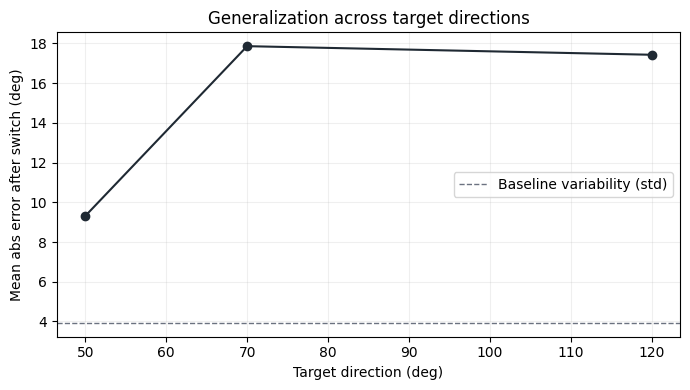

In [38]:
switch_target_angles = {
    121: 70,
    221: 50,
    321: 120,
}

n_after = 5
rows = []
for switch_trial, angle in switch_target_angles.items():
    start_idx = switch_trial - 1
    end_idx = min(start_idx + n_after, len(experiment_error))
    window = experiment_error[start_idx:end_idx]
    rows.append({
        'target_angle_deg': angle,
        'after_mean_abs_error_deg': float(np.nanmean(np.abs(window))),
    })

generalization_plot_df = pd.DataFrame(rows).sort_values('target_angle_deg')
display(generalization_plot_df)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(
    generalization_plot_df['target_angle_deg'],
    generalization_plot_df['after_mean_abs_error_deg'],
    marker='o',
    linewidth=1.5,
    color='#1f2933',
)
ax.axhline(
    baseline_motor_variability,
    color='#6b7280',
    linestyle='--',
    linewidth=1,
    label='Baseline variability (std)',
)
ax.set_xlabel('Target direction (deg)')
ax.set_ylabel('Mean abs error after switch (deg)')
ax.set_title('Generalization across target directions')
ax.grid(True, alpha=0.2)
ax.legend()
plt.tight_layout()
